In [1]:
from util import open_experiment_table
df = open_experiment_table()
df

experiment_id  generation_index   fitness  symmetry  \
0                   1                 0 -7.071068  0.000000   
1                   1                 0 -7.086142  0.000000   
2                   1                 0 -7.020524  0.000000   
3                   1                 0 -7.062783  0.000000   
4                   1                 0 -7.152976  0.571429   
...               ...               ...       ...       ...   
226495             12                64 -6.674304  0.000000   
226496             12                64 -5.281549  0.000000   
226497             12                64 -5.935944  0.000000   
226498             12                64 -5.000895  0.000000   
226499             12                64 -5.699889  0.000000   

                                             xy_positions  population_index  
0       [BodyState(core_position=Vector3([0.     , 0. ...                 0  
1       [BodyState(core_position=Vector3([0.        , ...                 1  
2       [BodyState(core_position=Vector3([0.     , 0. ...                 2  
3       [BodyState(core_position=Vector3([0.     , 0. ...                 3  
4       [BodyState(core_position=Vector3([0.        , ...                 4  
...                                                   ...               ...  
226495  [BodyState(core_position=Vector3([0.     , 0. ...                95  
226496  [BodyState(core_position=Vector3([0.     , 0. ...                96  
226497  [BodyState(core_position=Vector3([0.     , 0. ...                97  
226498  [BodyState(core_position=Vector3([0.     , 0. ...                98  
226499  [BodyState(core_position=Vector3([0.     , 0. ...                99  

[226500 rows x 6 columns]

In [2]:
from balance_compute import get_body_states_from_str, compute_balance_from_str_list
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [3]:
from pyrr import Quaternion, Matrix33, Vector3
import numpy as np

def rotate_vector_with_pyrr(quaternion, vector=Vector3([1.0, 0.0, 0.0])):
    # Create a Quaternion object from the given quaternion
    q = Quaternion(quaternion)
    # Convert the quaternion into a rotation matrix
    rotation_matrix = Matrix33.from_quaternion(q)
    # Apply the rotation matrix to the vector
    rotated_vector = rotation_matrix * vector
    # Return the rotated vector (you can ignore the z-component for 2D)
    return rotated_vector.xy



In [4]:
single_body = get_body_states_from_str(df["xy_positions"][0])
rotate_vector_with_pyrr(single_body[10].core_orientation)

Vector3([1.00000000e+00, 9.63655212e-18])

In [5]:
# len(df[df["experiment_id"]==6])/50

len(df[(df["experiment_id"] == 6) & (df["generation_index"] == 0)])

100

In [6]:
from tqdm import tqdm
def recompute_fitness(df, target=(5,5)):
    body_states = df["xy_positions"]
    fitnesses = []
    for i, single_robot_body_state_str in tqdm(enumerate(body_states), total=len(body_states)):
        # translate bodystates to readable objects
        single_robot_states = get_body_states_from_str(single_robot_body_state_str)
                
        # collect positions
        core_positions = [body_state.core_position for body_state in single_robot_states]
        final_x = core_positions[-1].x
        final_y = core_positions[-1].y

        fitnesses.append(np.sqrt((final_x-target[0])**2+(final_y-target[1])**2))

    df["recomputed_fitness"] = -fitnesses

def compute_balance(df):
    body_states = df["xy_positions"]
    balances = compute_balance_from_str_list(body_states)
    df["balance"] = balances

# recompute_fitness(df)
compute_balance(df)

/mnt/c/Users/satch/Desktop/MSc Artificial Intelligence/EC/revolve2-0.4.2-beta2/revolve2-0.4.2-beta2/examples/robot_bodybrain_ea/database_processes/balance_compute.py:20: RuntimeWarning: invalid value encountered in arcsin
  pitch = np.arcsin(-2.0*(q.x*q.z - q.w*q.y));


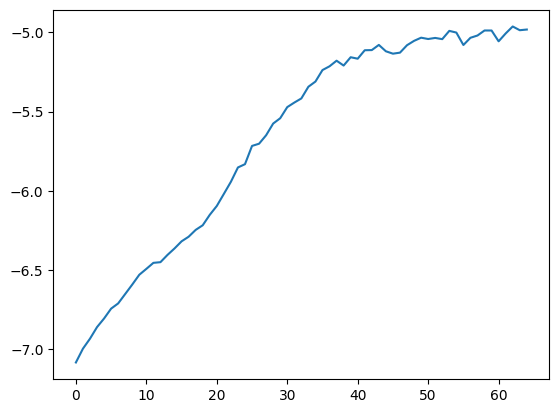

In [7]:
ex = 12
plt.plot(df[(df["experiment_id"] == ex)].groupby("generation_index")["fitness"].mean())
# plt.plot(df[(df["experiment_id"] == ex)].groupby("generation_index")["recomputed_fitness"].mean())

In [8]:
def plot_core_path_single_generation(body_states, exp, gen, path_type="vector", n_robots=-1, step_time=7, scale=3, seed=0, save_img=False, best_fitness_index=None, best_sym_index=None, best_bal_index=None):
    assert step_time > 0
    assert n_robots > 0 or n_robots == -1
    assert path_type in ["vector", "point", "both"]
    assert step_time > 0

    # select random robots if needed
    np.random.seed(seed)
    if n_robots == -1:
        n_robots = len(body_states)
    n_total_robots = len(body_states)
    body_states = np.random.choice(body_states, n_robots, replace=False)
    
    best_path_x, best_path_y = None, None
    best_sym_x, best_sym_y = None, None
    best_bal_x, best_bal_y = None, None

    for i, single_robot_body_state_str in enumerate(body_states):
        # translate bodystates to readable objects
        single_robot_states = get_body_states_from_str(single_robot_body_state_str)
        
        # collect positions
        core_positions = [body_state.core_position for body_state in single_robot_states]
        final_x = [core_positions[-1].x]
        final_y = [core_positions[-1].y]
        x = [core_position.x for core_position in core_positions][::step_time]+final_x
        y = [core_position.y for core_position in core_positions][::step_time]+final_y
        
        # collect xy vector orientations
        core_xy_orientations = [rotate_vector_with_pyrr(body_state.core_orientation) for body_state in single_robot_states]
        final_vector = [core_xy_orientations[-1]]
        vectors = np.array(core_xy_orientations[::step_time]+final_vector)

        if best_fitness_index is not None and i == best_fitness_index:
            best_fitness_x, best_fitness_y = x, y
            
        if best_sym_index is not None and i == best_sym_index:
            best_sym_x, best_sym_y = x, y

        if best_bal_index is not None and i == best_bal_index:
            best_bal_x, best_bal_y = x, y
            
        if path_type == "point" or path_type=="both":
            plt.plot(x[0], y[0], "go")      # starting point
            # plt.plot(x[-1], y[-1], "ro")    # end point
            plt.plot(x, y, color="grey")   # rest of path
            

        
        if path_type == "vector" or path_type=="both":
            U, V = vectors[:, 0], vectors[:, 1]
            plt.quiver(x, y, U, V, 
                       angles='xy', scale_units='xy', scale=scale, linewidths=0.5, width=0.005, color="grey")
            plt.quiver(final_x, final_y, final_vector[0][0], final_vector[0][1], 
                       angles='xy', scale_units='xy', scale=scale, color="red", linewidths=0.5, width=0.005)

    # plot best robot
    plt.plot(best_fitness_x, best_fitness_y, color="green", label="Best fitness")
    plt.plot(best_sym_x, best_sym_y, color="pink", linestyle="--", label="Best symmetry")
    plt.plot(best_bal_x, best_bal_y, color="red", linestyle=":", label="Best balance")
    
    # useful information to console
    print(f"Number of robots shown:    {n_robots}/{n_total_robots}")
    print(f"Number of timesteps shown: {len(core_positions)//step_time}/{len(core_positions)}")
    
    # plot target at (5,5)
    plt.plot([5], 5, "rx")
    
    # boilerplate readability
    plt.grid(True)
    plt.legend()
    plt.ylim(-1,6)
    plt.xlim(-1,6)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Core path for experiment " + str(exp) + " generation " + str(gen))
    if save_img:
        plt.savefig(f"pilot/paths/core_path_exp_{exp}_gen_{gen}.png", bbox_inches="tight")

    plt.show()


Number of robots shown:    100/100
Number of timesteps shown: 9/91


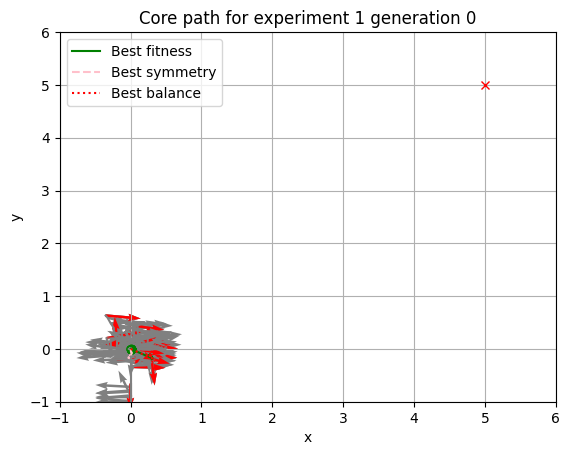

Number of robots shown:    100/100
Number of timesteps shown: 9/91


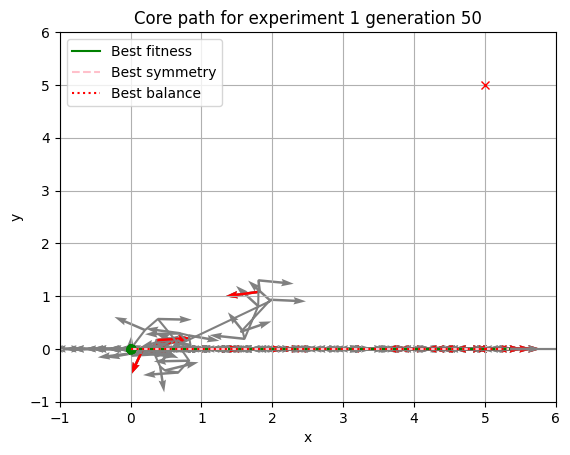

Number of robots shown:    100/100
Number of timesteps shown: 9/91


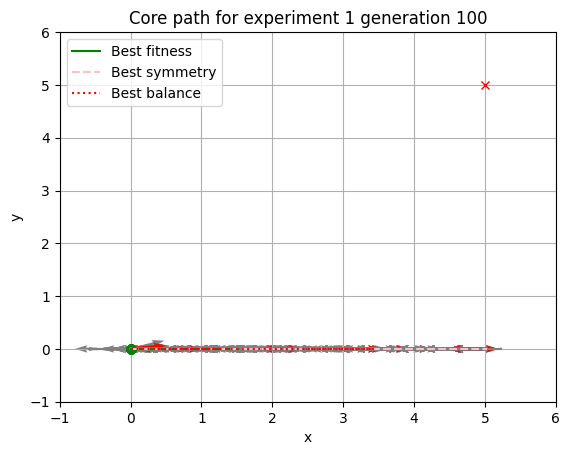

Number of robots shown:    100/100
Number of timesteps shown: 9/91


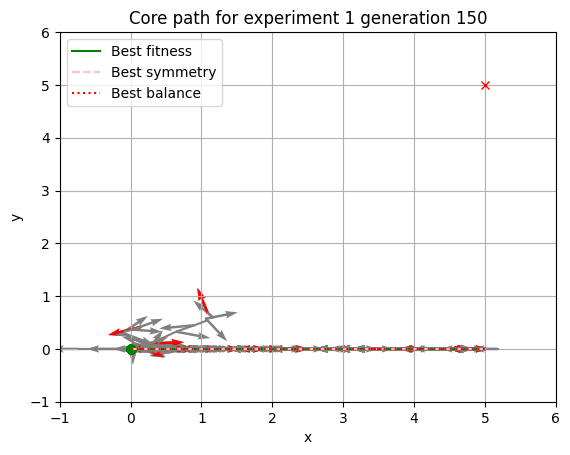

Number of robots shown:    100/100
Number of timesteps shown: 9/91


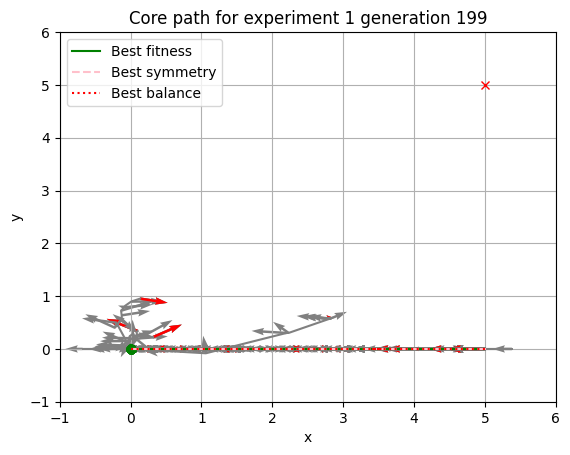

Number of robots shown:    100/100
Number of timesteps shown: 9/91


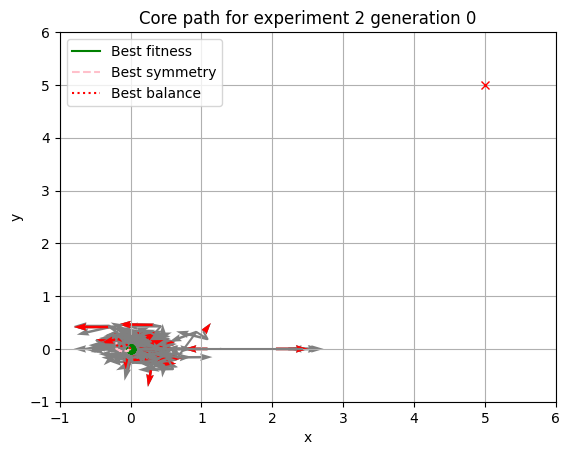

Number of robots shown:    100/100
Number of timesteps shown: 9/91


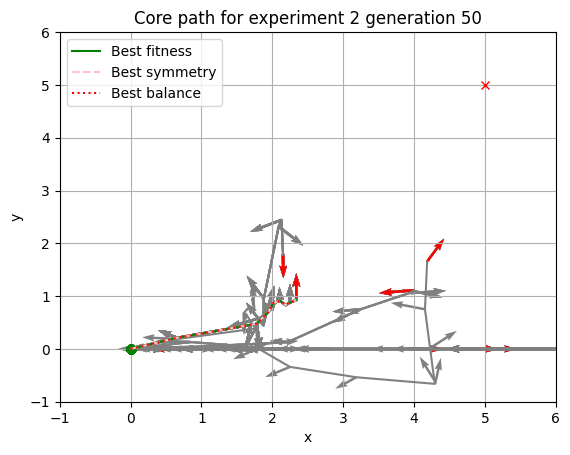

Number of robots shown:    100/100
Number of timesteps shown: 9/91


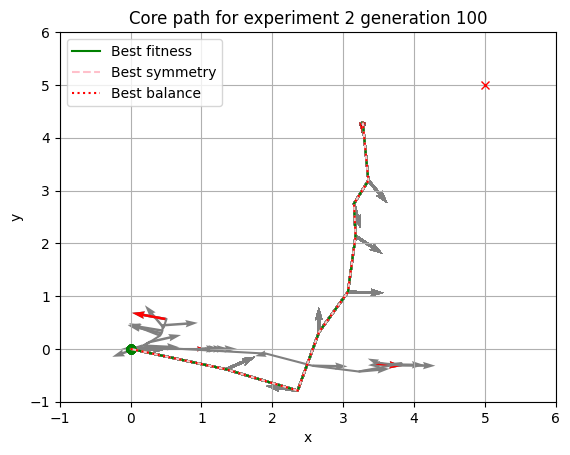

Number of robots shown:    100/100
Number of timesteps shown: 9/91


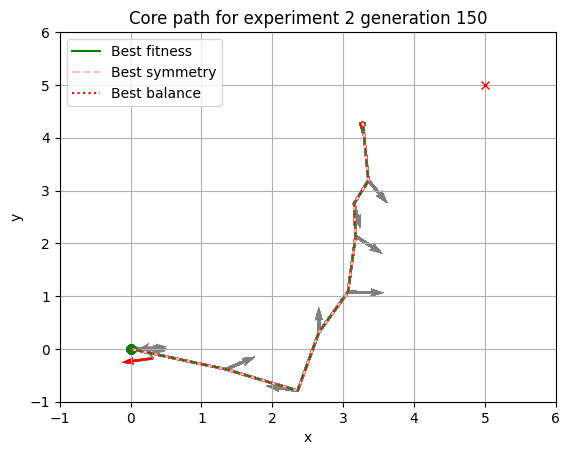

Number of robots shown:    100/100
Number of timesteps shown: 9/91


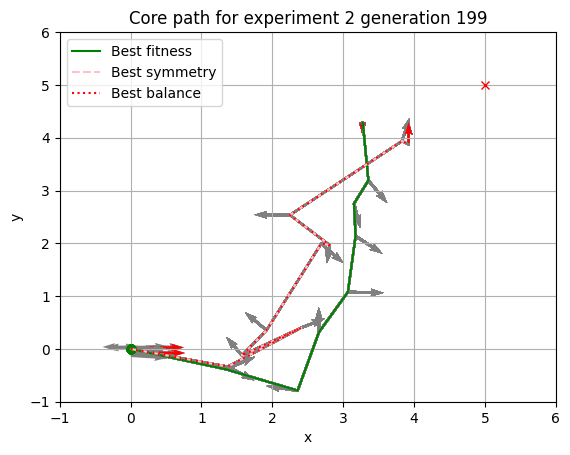

Number of robots shown:    100/100
Number of timesteps shown: 9/91


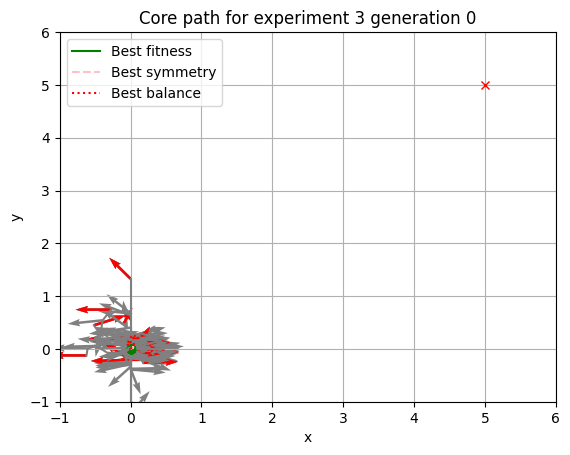

Number of robots shown:    100/100
Number of timesteps shown: 9/91


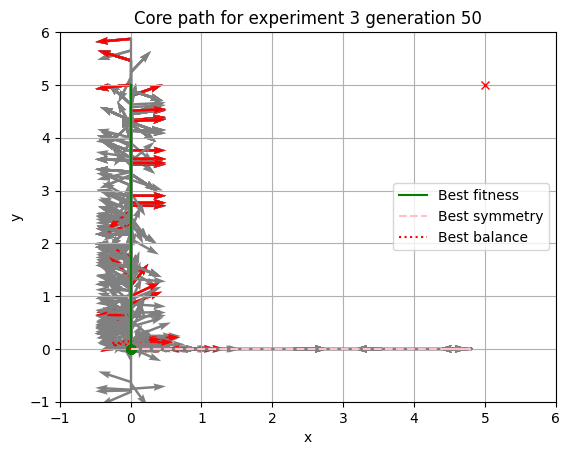

Number of robots shown:    100/100
Number of timesteps shown: 9/91


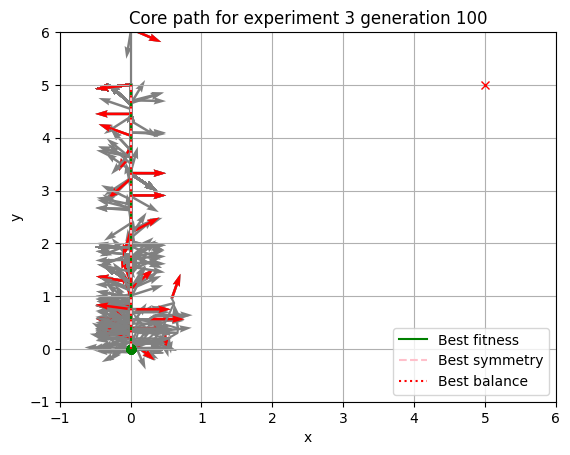

Number of robots shown:    100/100
Number of timesteps shown: 9/91


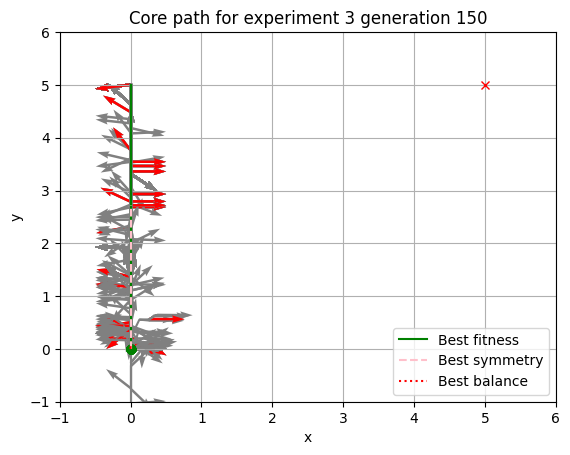

Number of robots shown:    100/100
Number of timesteps shown: 9/91


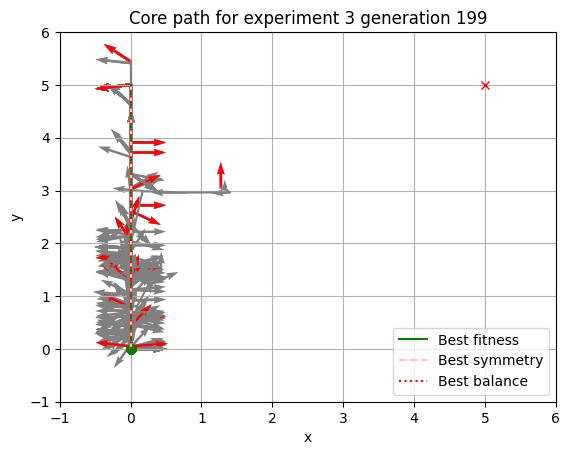

Number of robots shown:    100/100
Number of timesteps shown: 9/91


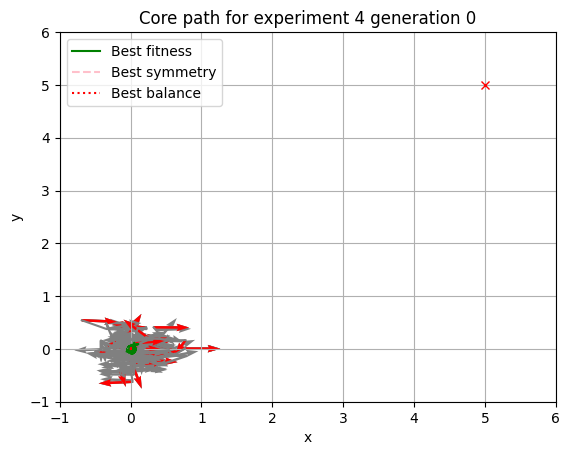

Number of robots shown:    100/100
Number of timesteps shown: 9/91


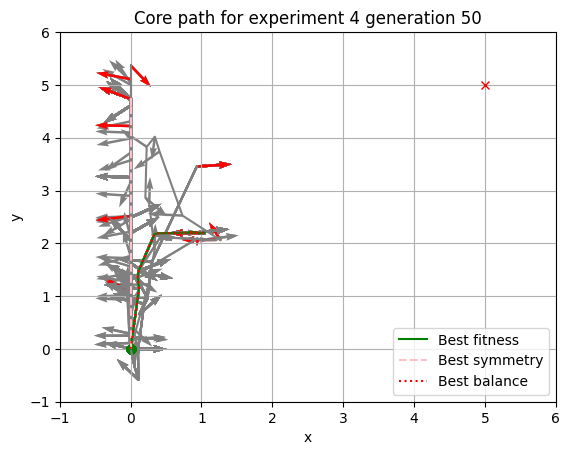

Number of robots shown:    100/100
Number of timesteps shown: 9/91


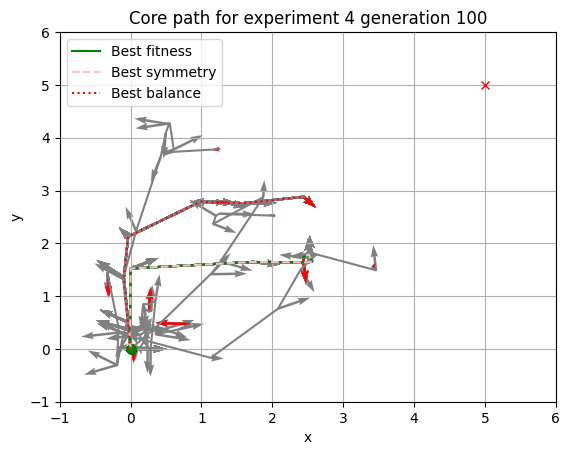

Number of robots shown:    100/100
Number of timesteps shown: 9/91


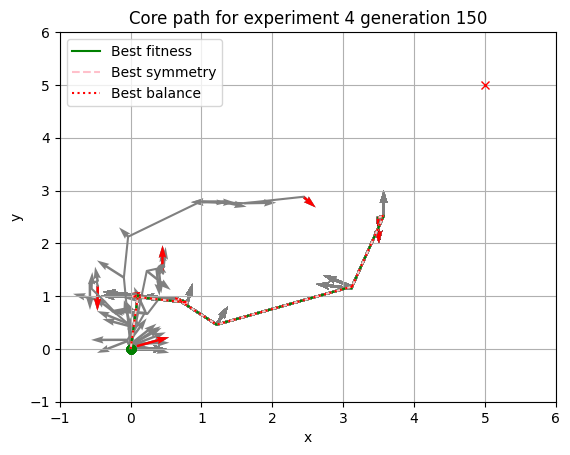

Number of robots shown:    100/100
Number of timesteps shown: 9/91


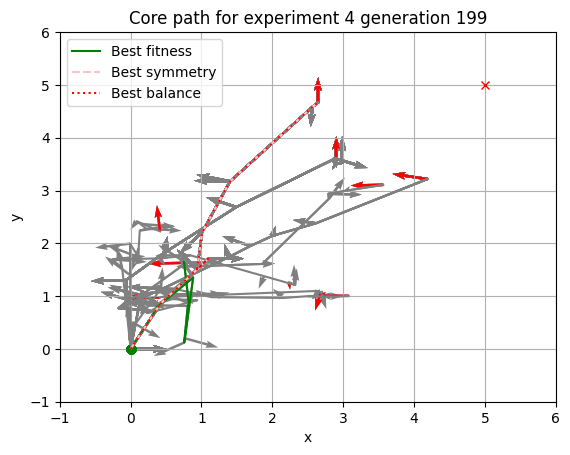

Number of robots shown:    100/100
Number of timesteps shown: 9/91


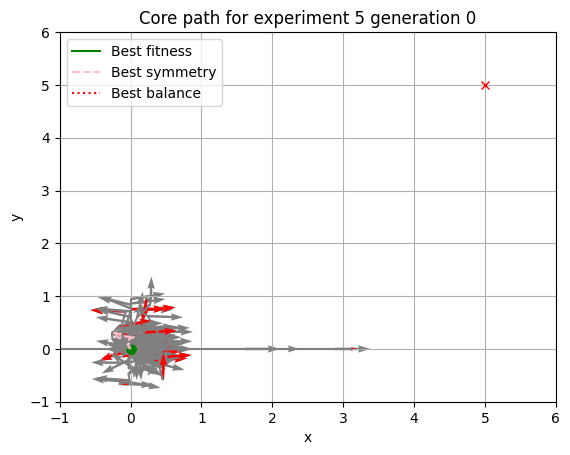

Number of robots shown:    100/100
Number of timesteps shown: 9/91


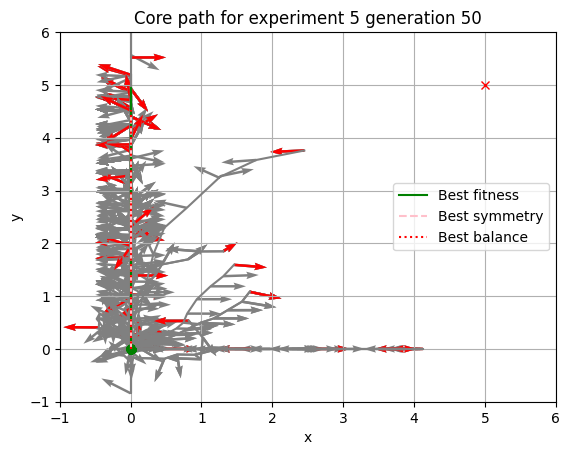

Number of robots shown:    100/100
Number of timesteps shown: 9/91


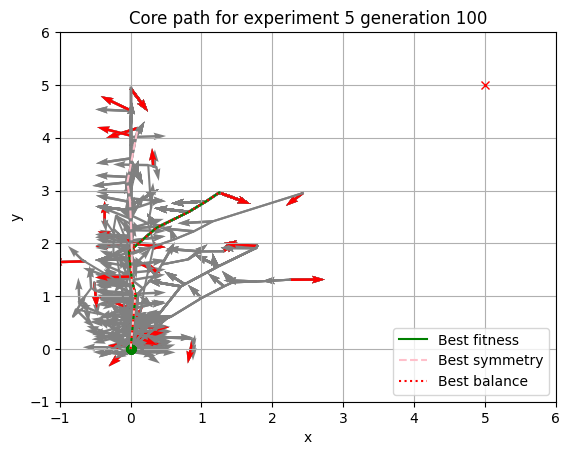

Number of robots shown:    100/100
Number of timesteps shown: 9/91


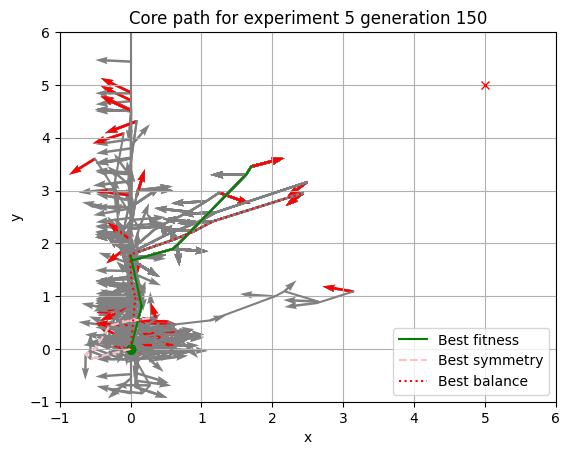

Number of robots shown:    100/100
Number of timesteps shown: 9/91


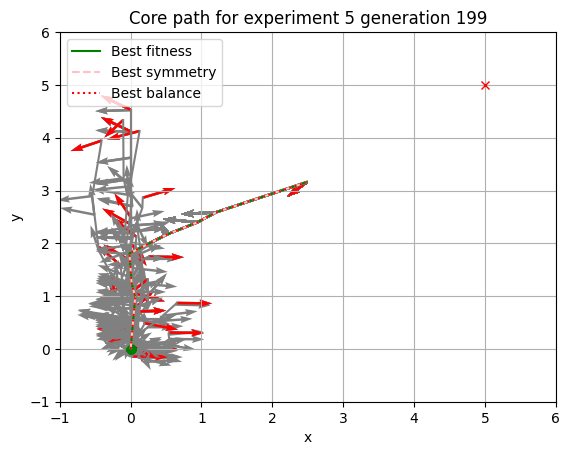

Number of robots shown:    100/100
Number of timesteps shown: 9/91


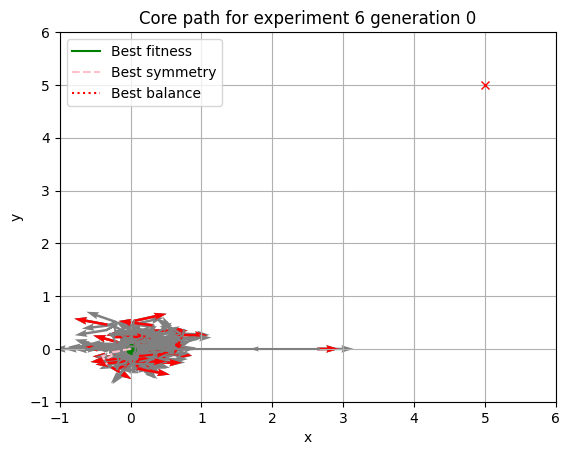

Number of robots shown:    100/100
Number of timesteps shown: 9/91


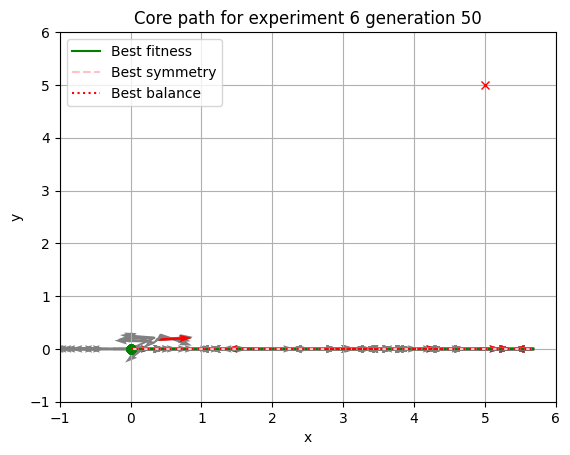

Number of robots shown:    100/100
Number of timesteps shown: 9/91


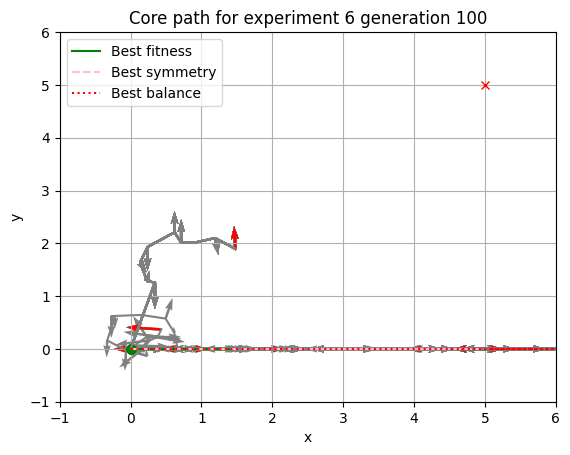

Number of robots shown:    100/100
Number of timesteps shown: 9/91


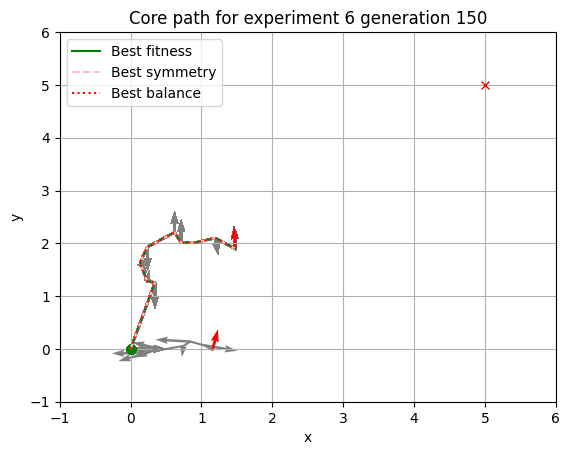

Number of robots shown:    100/100
Number of timesteps shown: 9/91


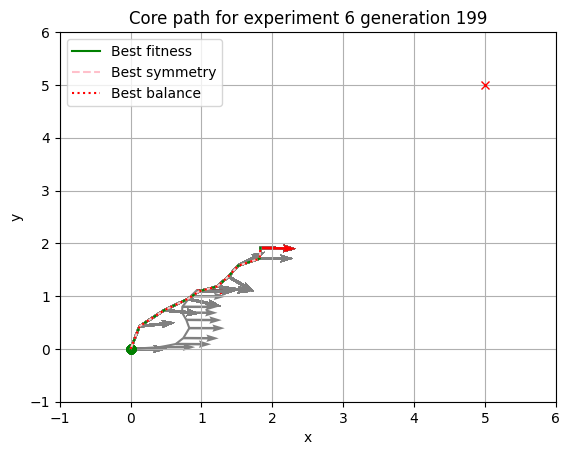

Number of robots shown:    100/100
Number of timesteps shown: 9/91


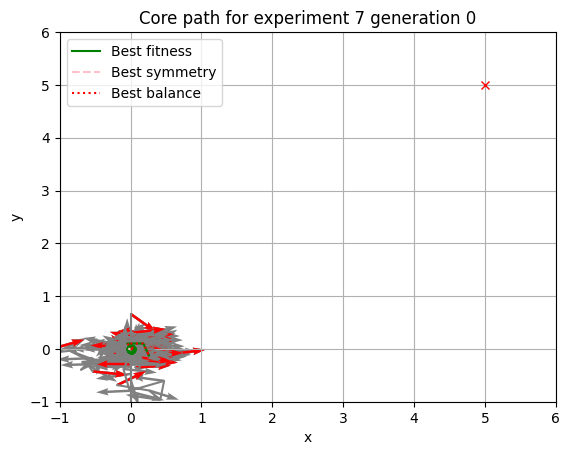

Number of robots shown:    100/100
Number of timesteps shown: 9/91


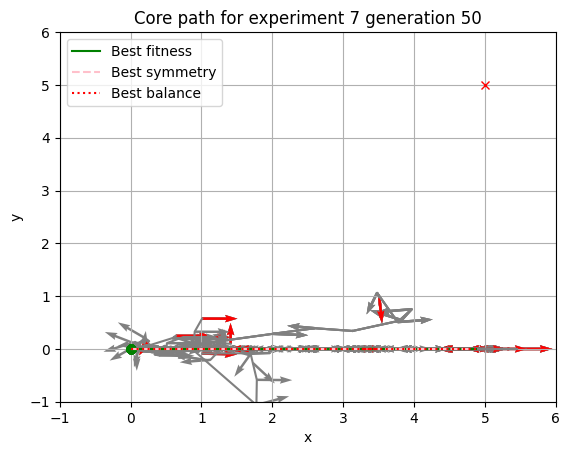

Number of robots shown:    100/100
Number of timesteps shown: 9/91


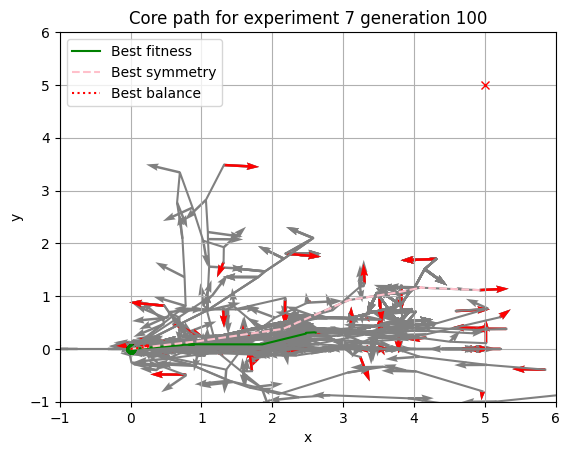

Number of robots shown:    100/100
Number of timesteps shown: 9/91


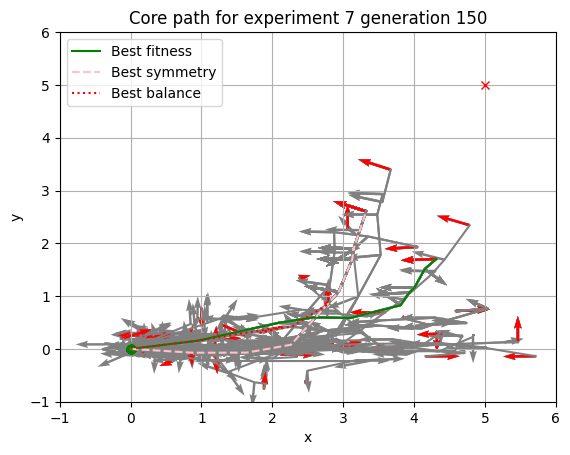

Number of robots shown:    100/100
Number of timesteps shown: 9/91


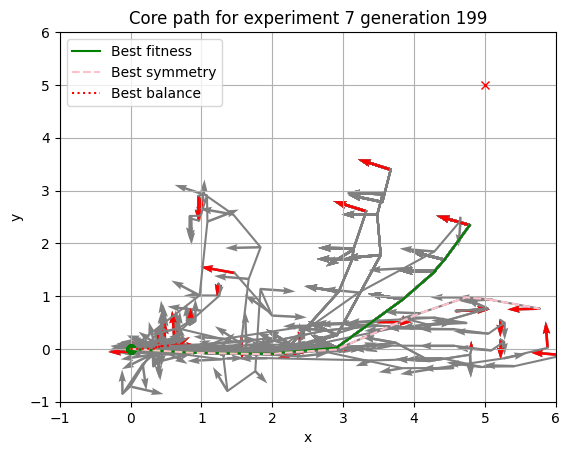

Number of robots shown:    100/100
Number of timesteps shown: 9/91


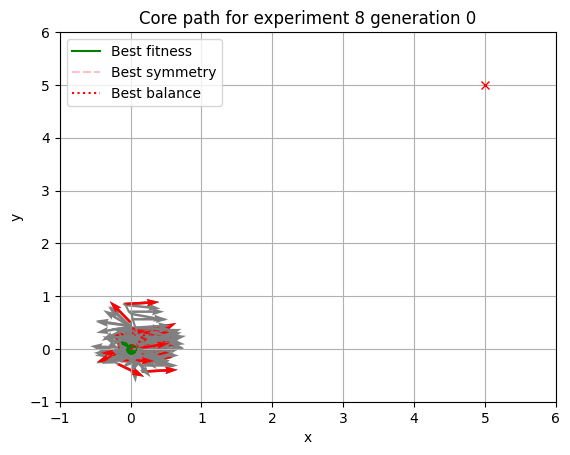

Number of robots shown:    100/100
Number of timesteps shown: 9/91


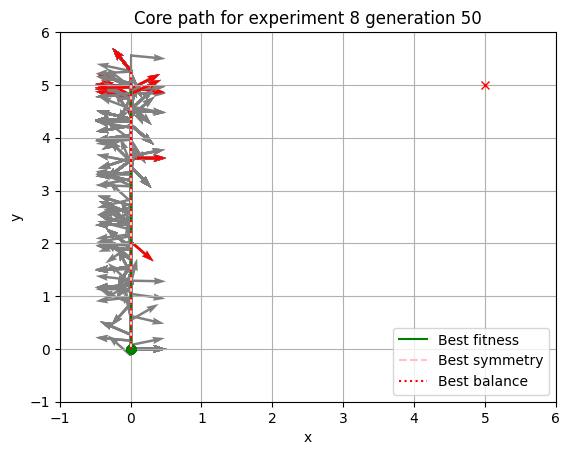

Number of robots shown:    100/100
Number of timesteps shown: 9/91


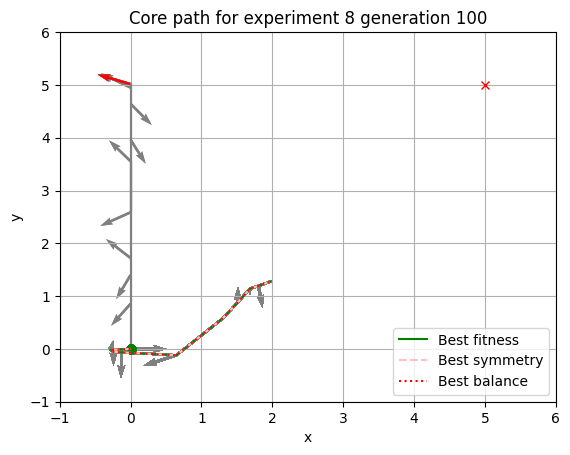

Number of robots shown:    100/100
Number of timesteps shown: 9/91


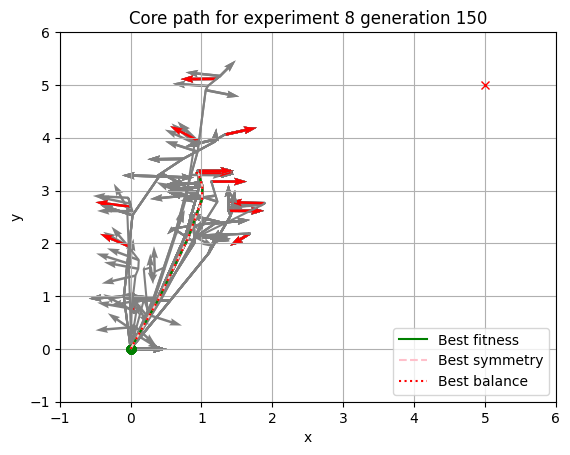

Number of robots shown:    100/100
Number of timesteps shown: 9/91


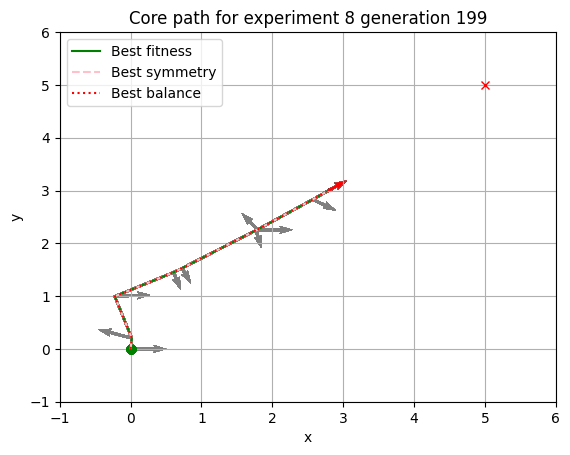

Number of robots shown:    100/100
Number of timesteps shown: 9/91


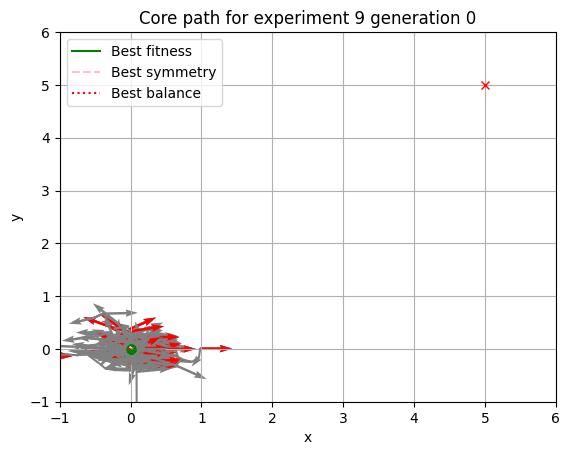

Number of robots shown:    100/100
Number of timesteps shown: 9/91


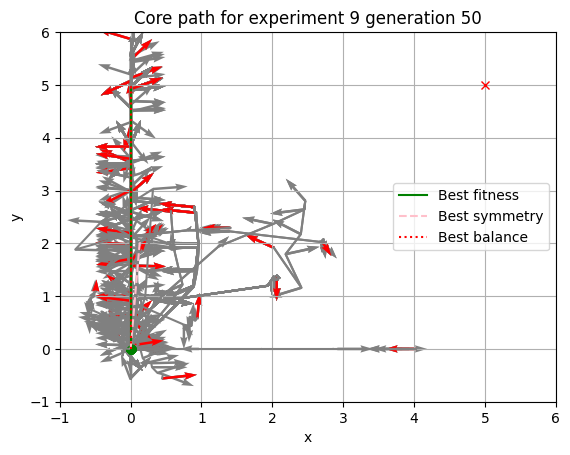

Number of robots shown:    100/100
Number of timesteps shown: 9/91


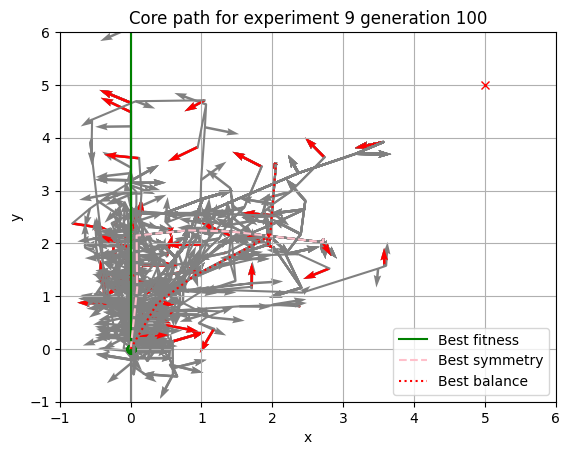

Number of robots shown:    100/100
Number of timesteps shown: 9/91


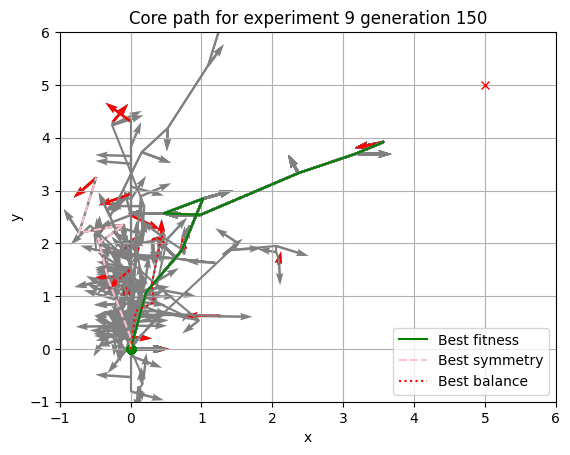

Number of robots shown:    100/100
Number of timesteps shown: 9/91


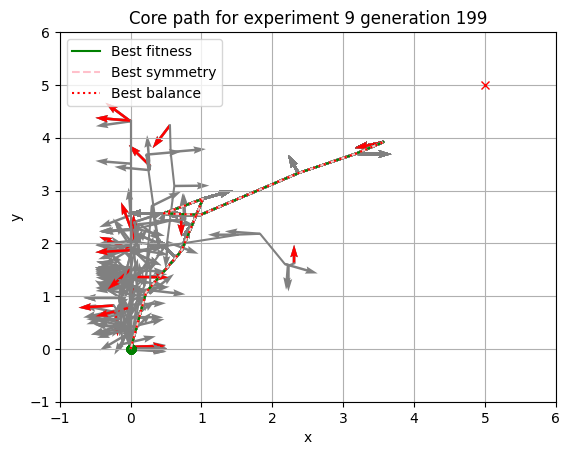

Number of robots shown:    100/100
Number of timesteps shown: 9/91


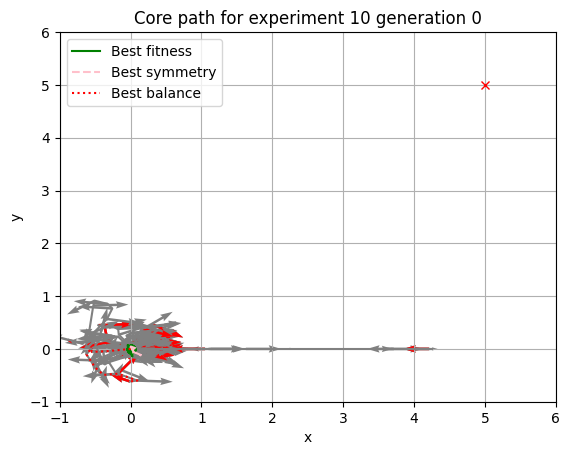

Number of robots shown:    100/100
Number of timesteps shown: 9/91


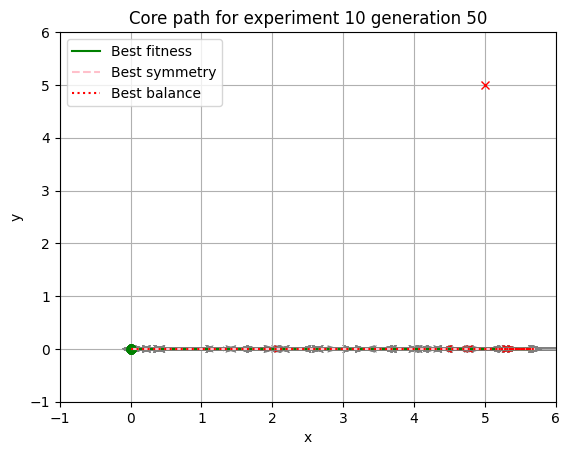

Number of robots shown:    100/100
Number of timesteps shown: 9/91


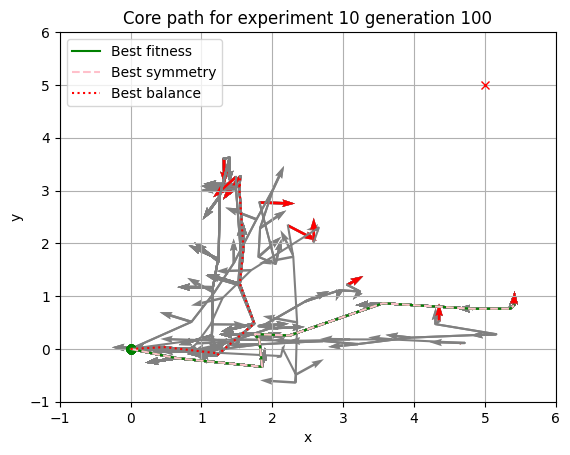

Number of robots shown:    100/100
Number of timesteps shown: 9/91


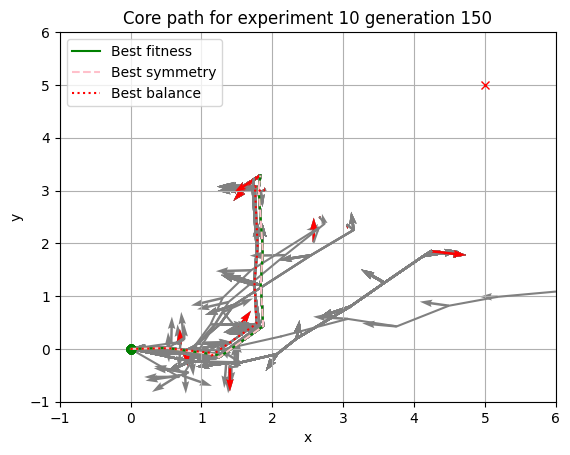

Number of robots shown:    100/100
Number of timesteps shown: 9/91


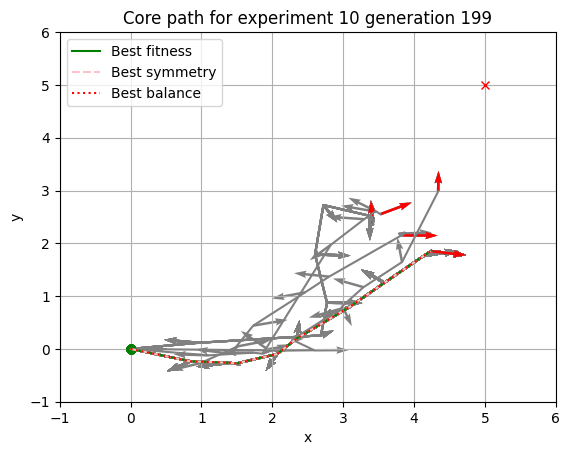

Number of robots shown:    100/100
Number of timesteps shown: 9/91


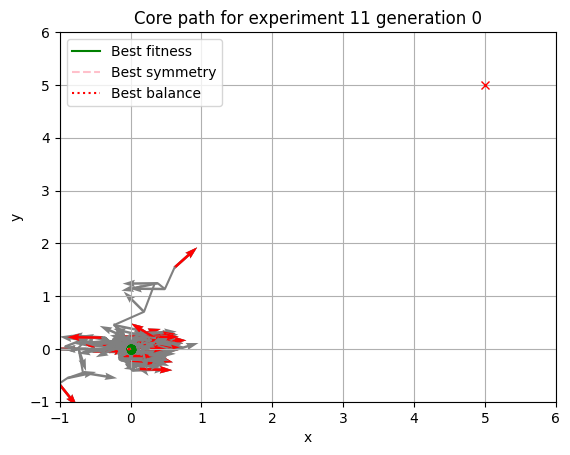

Number of robots shown:    100/100
Number of timesteps shown: 9/91


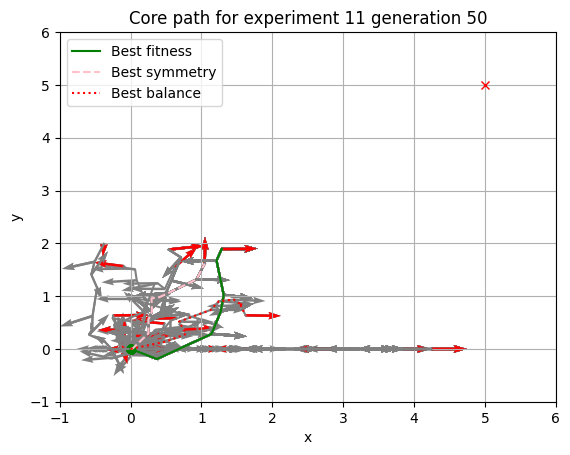

Number of robots shown:    100/100
Number of timesteps shown: 9/91


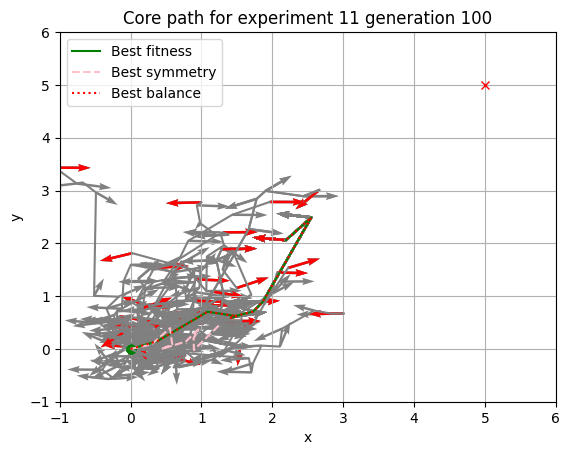

Number of robots shown:    100/100
Number of timesteps shown: 9/91


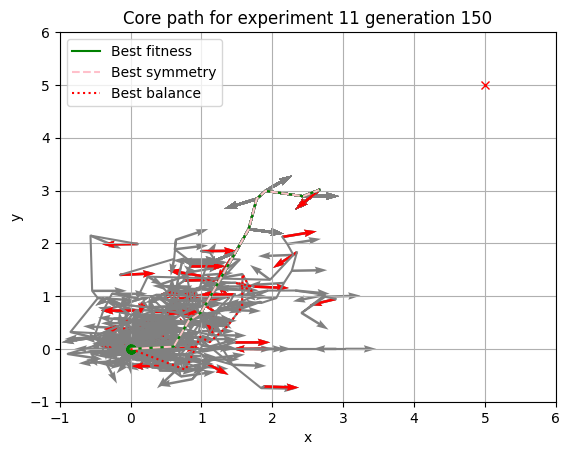

Number of robots shown:    100/100
Number of timesteps shown: 9/91


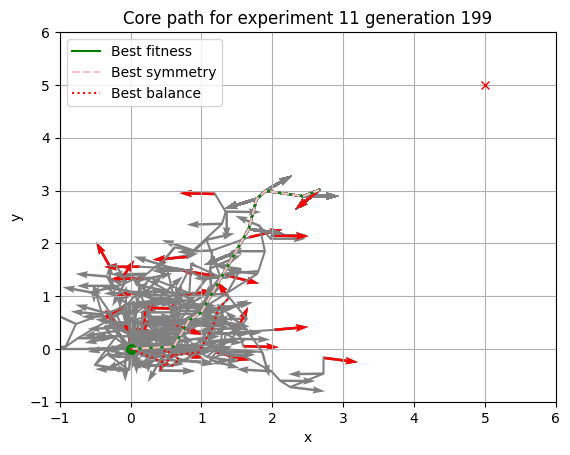

Number of robots shown:    100/100
Number of timesteps shown: 9/91


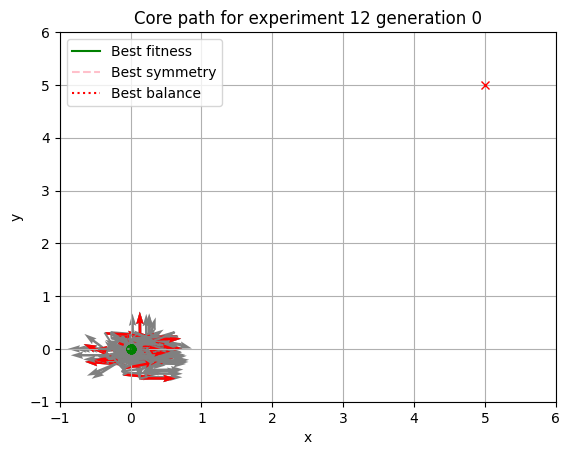

Number of robots shown:    100/100
Number of timesteps shown: 9/91


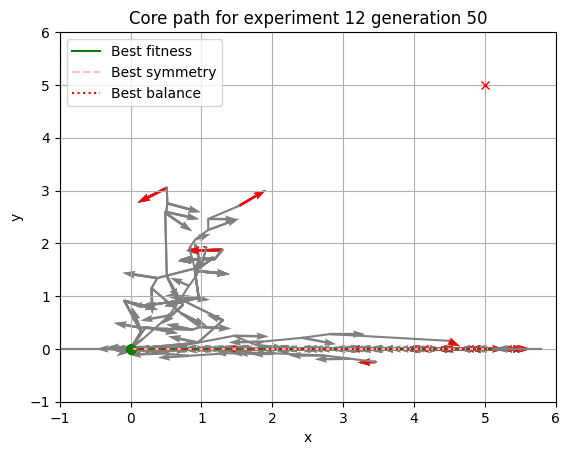

Number of robots shown:    100/100
Number of timesteps shown: 9/91


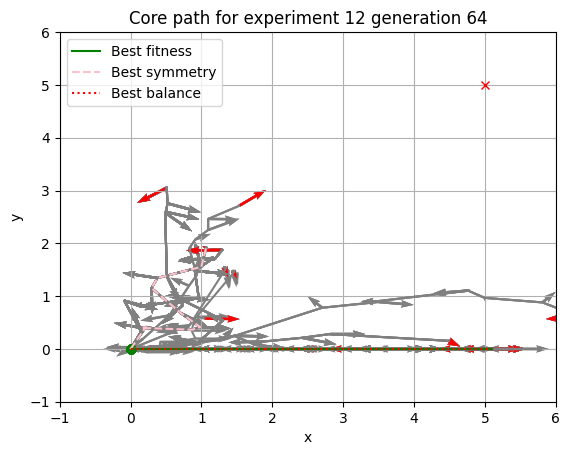

In [9]:
for ex in range(1,13):
    for i, gen in enumerate(df[df["experiment_id"] == ex]["generation_index"].unique()):
        if i%50==0 or i==max(df[df["experiment_id"] == ex]["generation_index"].unique()):
            df_sub = df[(df["experiment_id"] == ex) & (df["generation_index"] == gen)]
            best_fitness_index = np.argmax(df_sub["fitness"])
            best_sym_index = np.argmax(df_sub["symmetry"])
            best_bal_index = np.argmax(df_sub["balance"])
            body_states = df[(df["experiment_id"] == ex) & (df["generation_index"] == gen)]["xy_positions"]
            plot_core_path_single_generation(body_states, ex, gen, path_type="both", n_robots=-1, step_time=10, 
                                             scale=2, seed=None, best_fitness_index=best_fitness_index, best_sym_index=best_sym_index, 
                                             best_bal_index=best_bal_index, save_img=True)
            # break

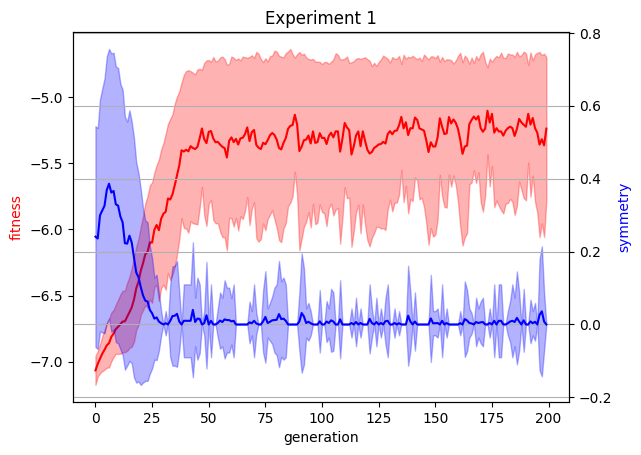

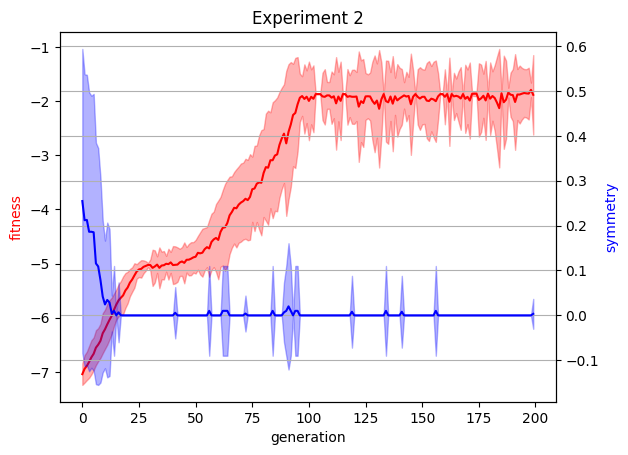

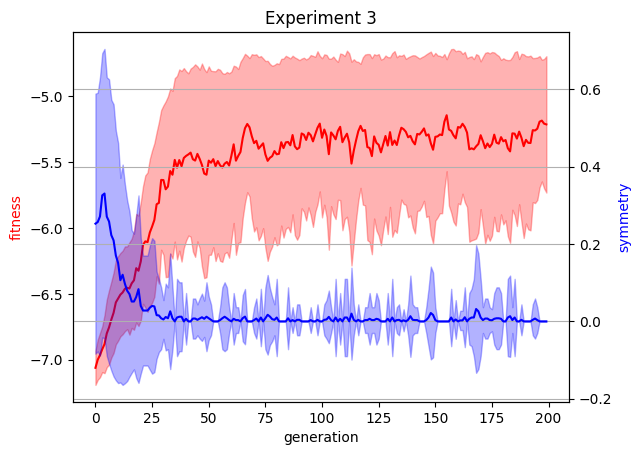

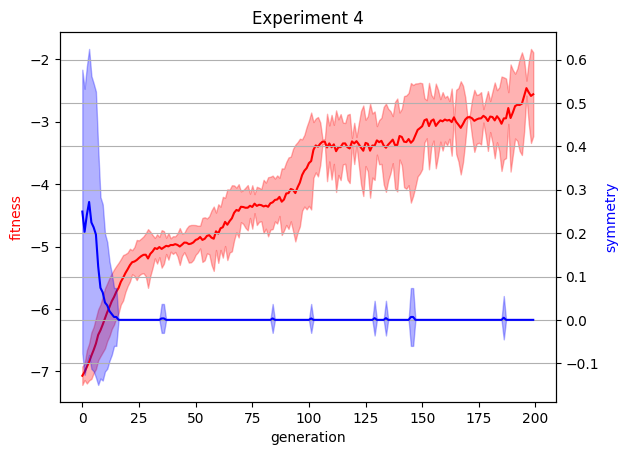

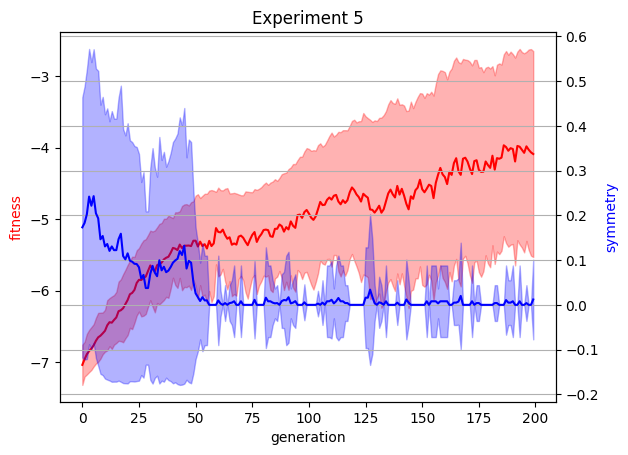

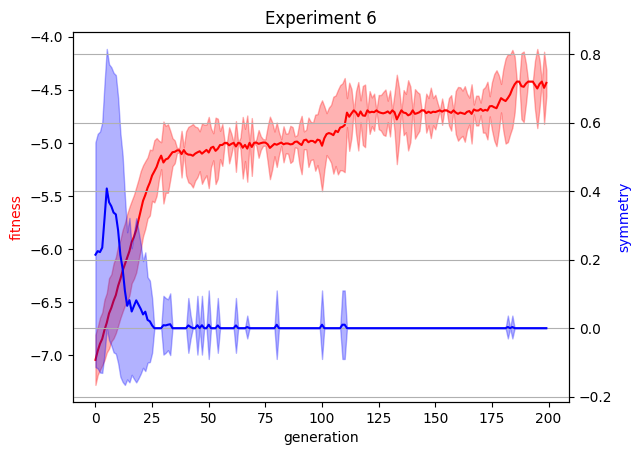

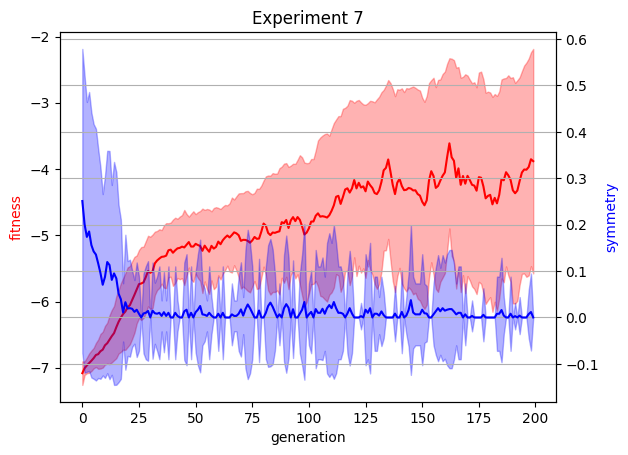

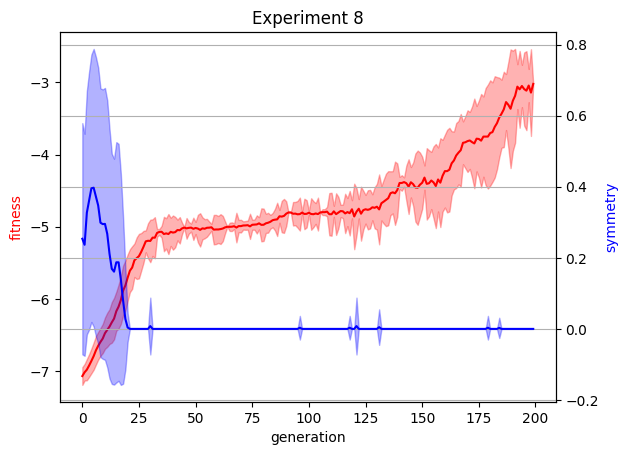

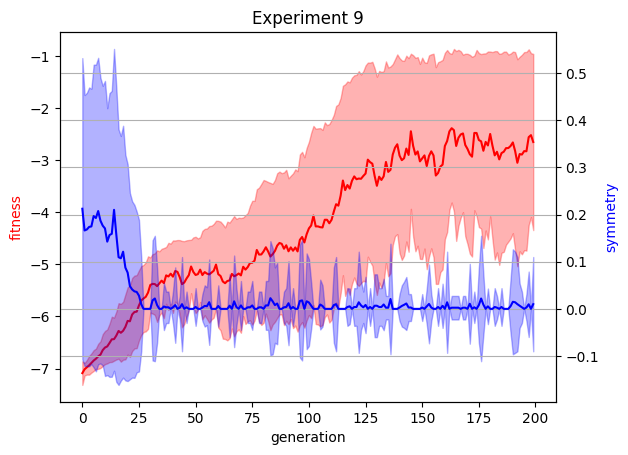

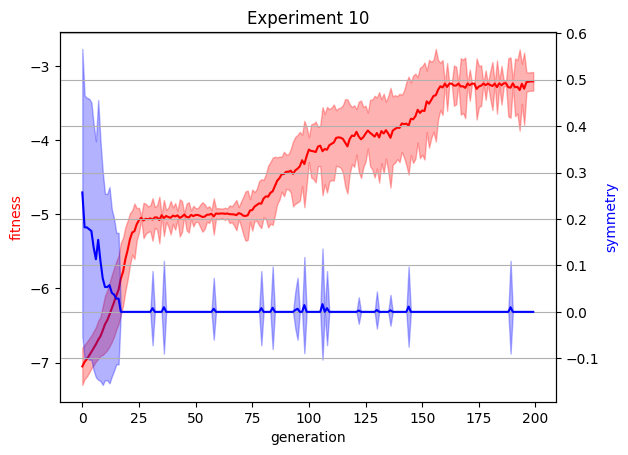

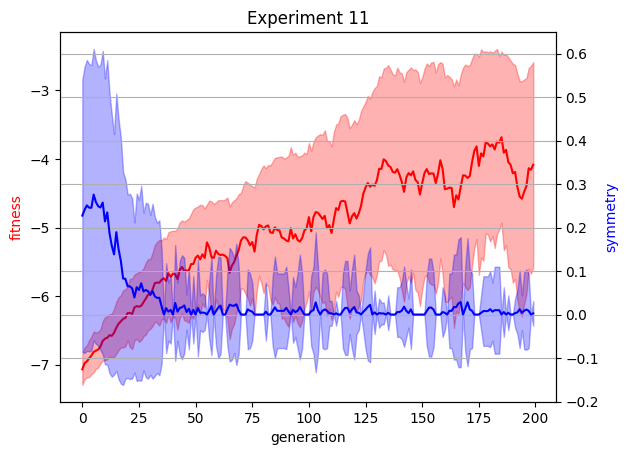

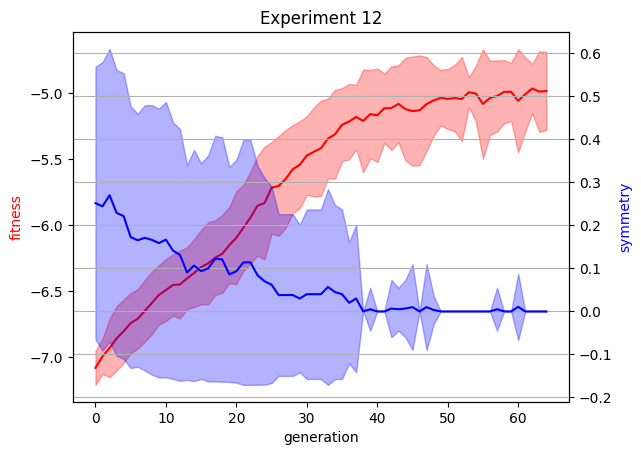

In [14]:
for ex in range(1,13):
    fig, ax1 = plt.subplots()
    
    plt.title(f"Experiment {ex}")
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax1.set_xlabel('generation')
    ax1.set_ylabel('fitness', color="red")
    ax2.set_ylabel('symmetry', color="blue")

    m1 = df[(df["experiment_id"] == ex)].groupby("generation_index")["fitness"].mean()
    m2 = df[(df["experiment_id"] == ex)].groupby("generation_index")["symmetry"].mean()
    ax1.plot(m1, color="red")
    ax2.plot(m2, color="blue")

    std_1 = df[(df["experiment_id"] == ex)].groupby("generation_index")["fitness"].std()
    std_2 = df[(df["experiment_id"] == ex)].groupby("generation_index")["symmetry"].std()
    ax1.fill_between(np.arange(len(m1)), m1-std_1, m1+std_1, color="red", alpha=0.3)
    ax2.fill_between(np.arange(len(m2)), m2-std_2, m2+std_2, color="blue", alpha=0.3)
    
    plt.grid()
    plt.savefig(f"pilot/fitsym/fitness_symmetry_exp_{ex}.png", bbox_inches="tight")
    
    plt.show()

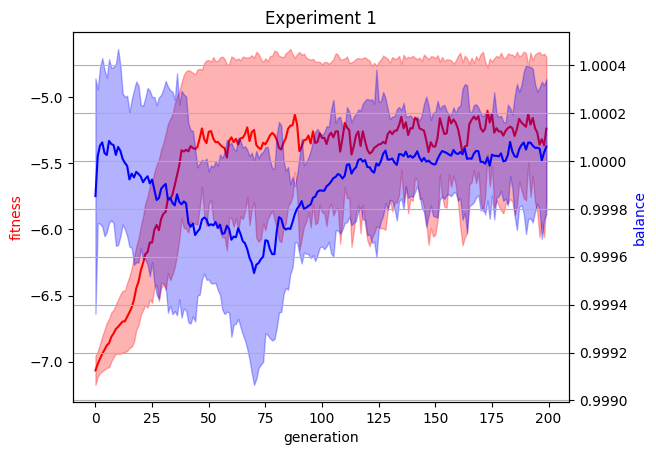

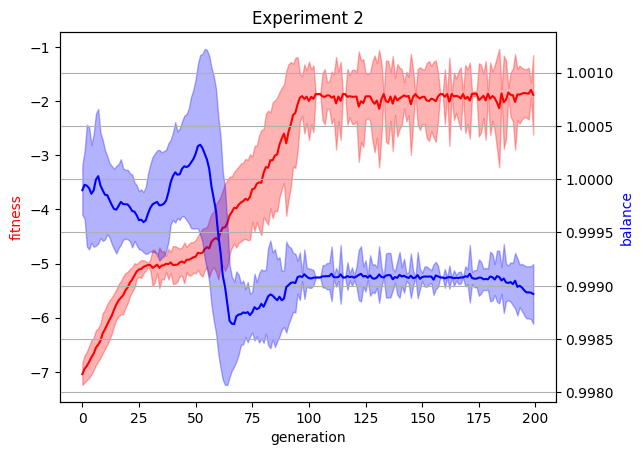

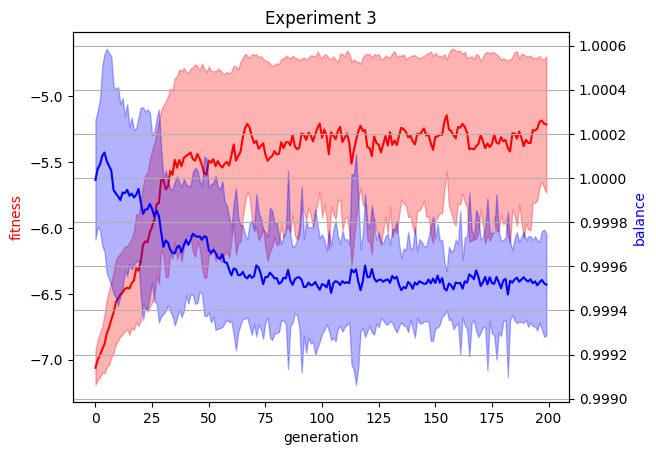

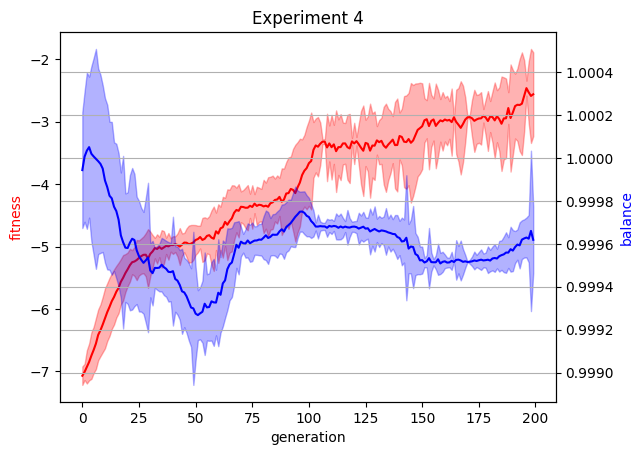

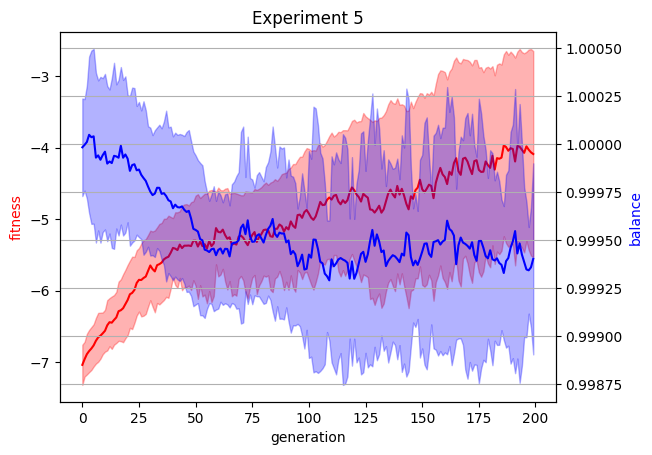

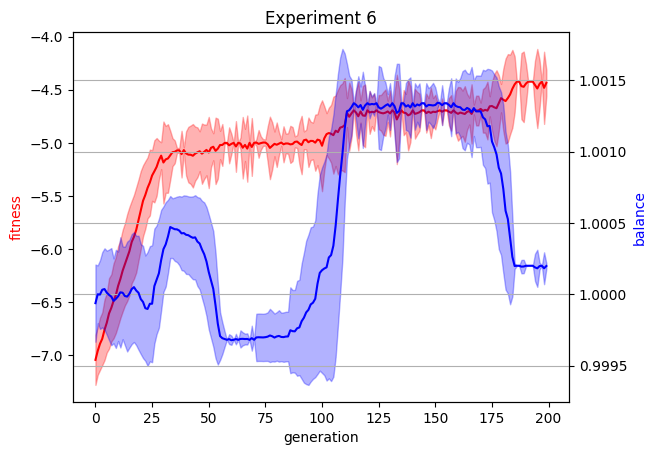

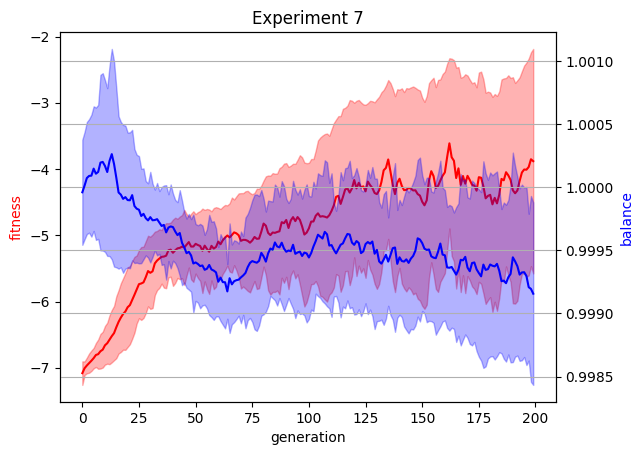

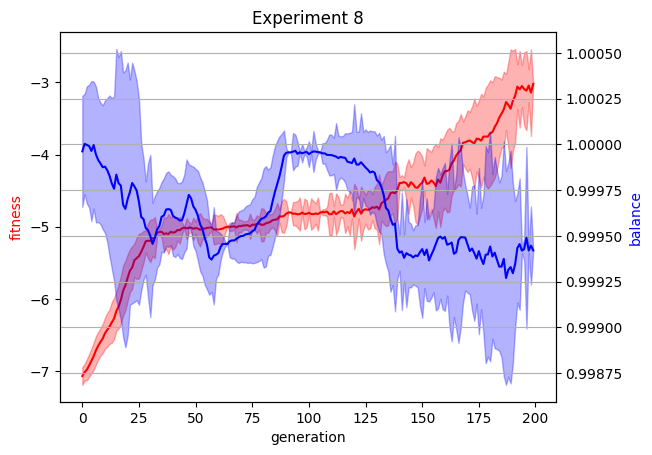

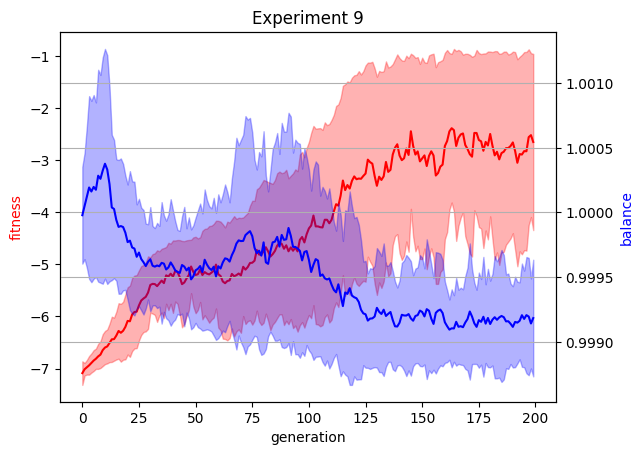

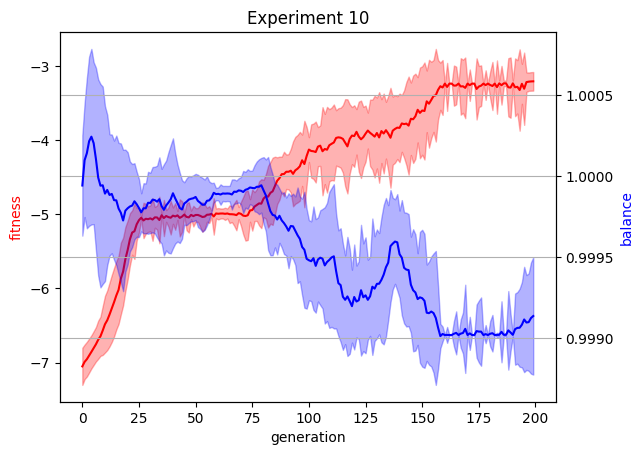

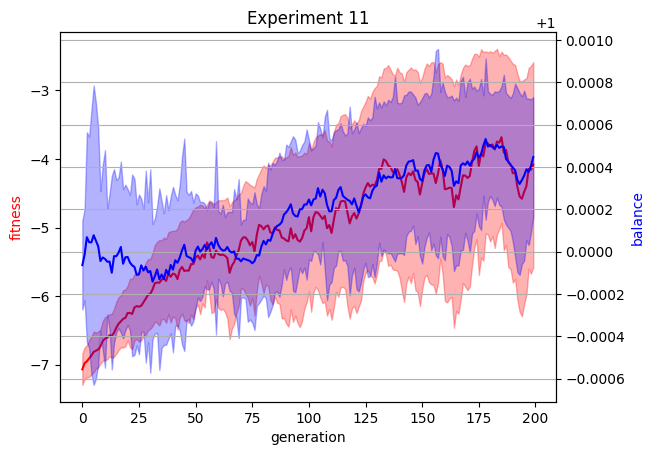

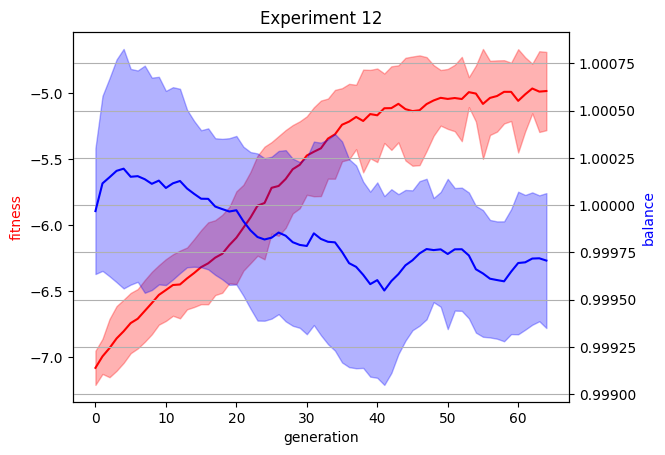

In [19]:
for ex in range(1,13):
    fig, ax1 = plt.subplots()
    
    plt.title(f"Experiment {ex}")
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax1.set_xlabel('generation')
    ax1.set_ylabel('fitness', color="red")
    ax2.set_ylabel('balance', color="blue")
    
    m1 = df[(df["experiment_id"] == ex)].groupby("generation_index")["fitness"].mean()
    # m1max = df[(df["experiment_id"] == ex)].groupby("generation_index")["fitness"].max()
    m2 = df[(df["experiment_id"] == ex)].groupby("generation_index")["balance"].mean()
    ax1.plot(m1, color="red")
    # ax1.plot(m1max, linestyle="--", color="red")
    ax2.plot(m2, color="blue")

    std_1 = df[(df["experiment_id"] == ex)].groupby("generation_index")["fitness"].std()
    std_2 = df[(df["experiment_id"] == ex)].groupby("generation_index")["balance"].std()
    ax1.fill_between(np.arange(len(m1)), m1-std_1, m1+std_1, color="red", alpha=0.3)
    ax2.fill_between(np.arange(len(m2)), m2-std_2, m2+std_2, color="blue", alpha=0.3)
    
    plt.grid()
    plt.savefig(f"pilot/fitbal/fitness_balance_exp_{ex}.png", bbox_inches="tight")
    
    plt.show()

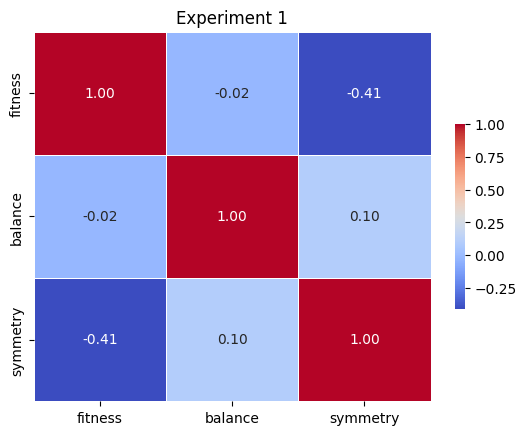

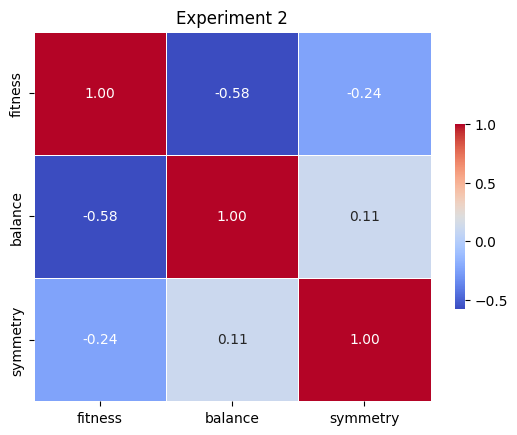

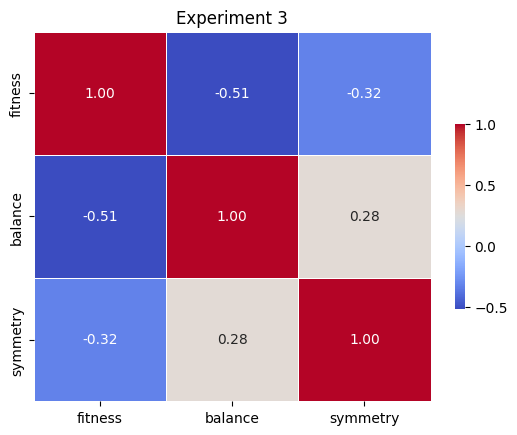

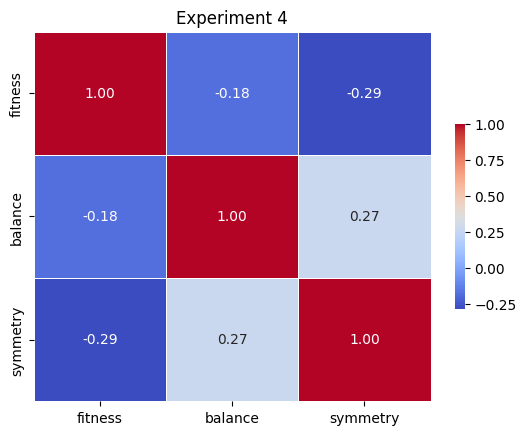

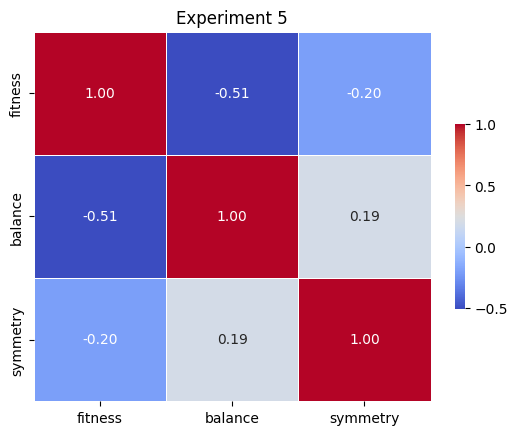

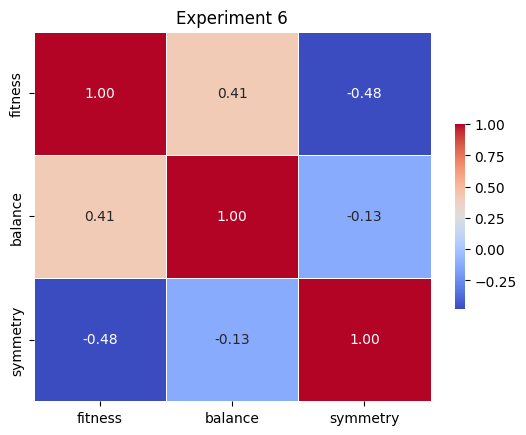

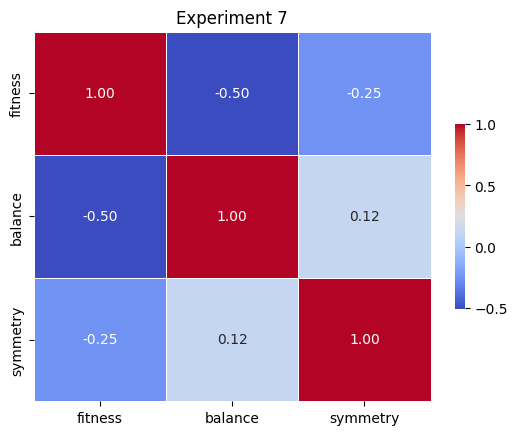

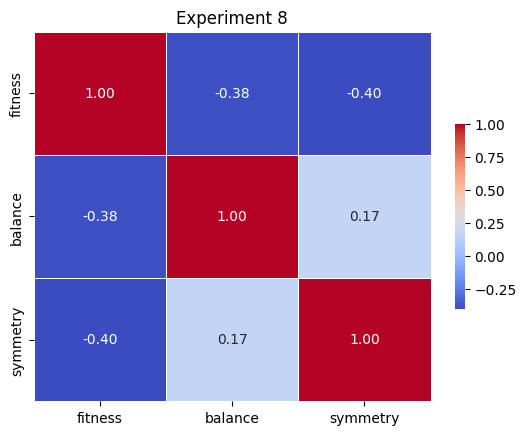

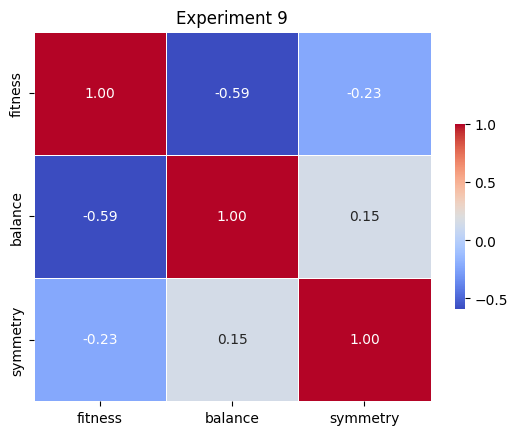

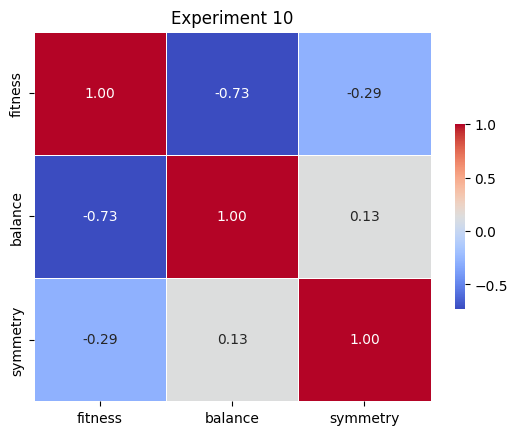

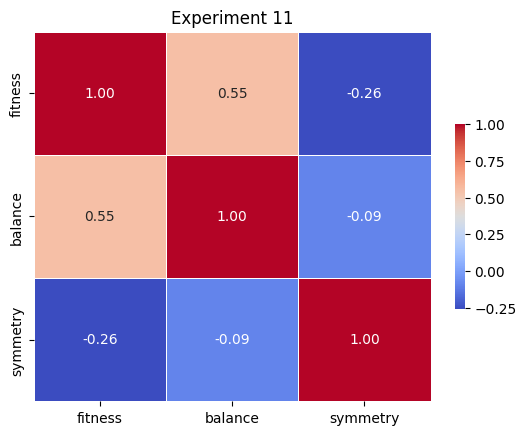

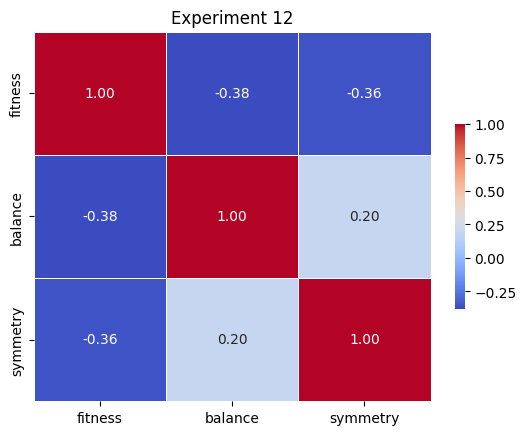

In [12]:
import seaborn as sns

for ex in range(1,13):
    corr = df[(df["experiment_id"] == ex)][["fitness", "balance", "symmetry"]].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
                xticklabels=corr.columns, yticklabels=corr.columns,
                linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(f"Experiment {ex}")
    plt.savefig(f"pilot/fitbalsym/corr_exp_{ex}.png", bbox_inches="tight")
    plt.show()